# Table of Contents

##### [1. Graph Analysis](#1)
##### &nbsp; &nbsp; [1.1. Analysis of Review Distributions](#1-1)
##### &nbsp; &nbsp; [1.2. Game Review Aggregation](#1-2)
##### &nbsp; &nbsp; [1.3. Graph Creation](#1-3)
##### &nbsp; &nbsp; [1.4. Networks Through Time](#1-4)
##### &nbsp; &nbsp; [1.5. Powelaw Distributions](#1-5)
##### &nbsp; &nbsp; [1.6. Degree Correlations](#1-6)
##### &nbsp; &nbsp; [1.7. Clustering Coefficient](#1-7)
##### &nbsp; &nbsp; [1.8. Network Visualization on Gephi](#1-8)


##### [2. Game Aesthetics Analysis](#2)
##### &nbsp; &nbsp; [2.1. EDA and Data Loading](#2-1)
##### &nbsp; &nbsp; [2.2. Text pre-processing](#2-2)
##### &nbsp; &nbsp; [2.3. Pattern Matching](#2-3)
##### &nbsp; &nbsp; [2.4. Feature Description](#2-4)


# Graph Analysis <a class="anchor" id="1"></a>
In this section is shown the graph analysis.

In [ ]:
# import Libraries
from ast import literal_eval
import itertools
from functools import reduce
import operator
from datetime import datetime
from dateutil import parser
import networkx as nx
from networkx.algorithms import bipartite
import collections
import powerlaw

In [ ]:
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1sOGmTqN8jPZcpysXtNZJcR5EZndCyopL/view?usp=sharing' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':'1sOGmTqN8jPZcpysXtNZJcR5EZndCyopL'}) 
downloaded.GetContentFile('metacritic_user_reviews_full_full.csv')  
df = pd.read_csv('metacritic_user_reviews_full_full.csv', usecols = ['reviewer', 'title', 'date', 'user_score'], parse_dates = ['date'])
# Dataset is now stored in a Pandas Dataframe
df.head()

## Analysis of review distributions <a class="anchor" id="1-1"></a>
First we analise the percentages of negative, neutrall, and positive user reviews along the years. For that we first need to "map" each score to a specific category. that is done based on the scheme used by the website itself, also reflected by the colors of the reviews. Then, we simply plot those distributions.

In [ ]:
# function to map scores to class
def map_review_category(score):
  if score > 7:
    category = 'positive'
  elif score >4: 
    category = 'neutral'
  else:
    category = 'negative'
  return category


In [ ]:
#Applying and counting
df['user_opinion'] = df.user_score.apply(lambda score: map_review_category(score))
df['year'] =  df.date.apply(lambda date: date.year)
df_grouped= df.groupby(['year', 'user_opinion']).count()[['title']]
df_grouped = df_grouped.reset_index().pivot(index='year',columns='user_opinion',values='title')
df_grouped_percentage = df_grouped.copy().T
df_grouped_percentage

In [ ]:
#converting to percentages
for column in df_grouped_percentage.columns.values:
    df_grouped_percentage[column] = df_grouped_percentage[column].apply(lambda x: x/np.sum(df_grouped_percentage[column]))
df_grouped_percentage = df_grouped_percentage.T
df_grouped_percentage

Mounted at /content/gdrive


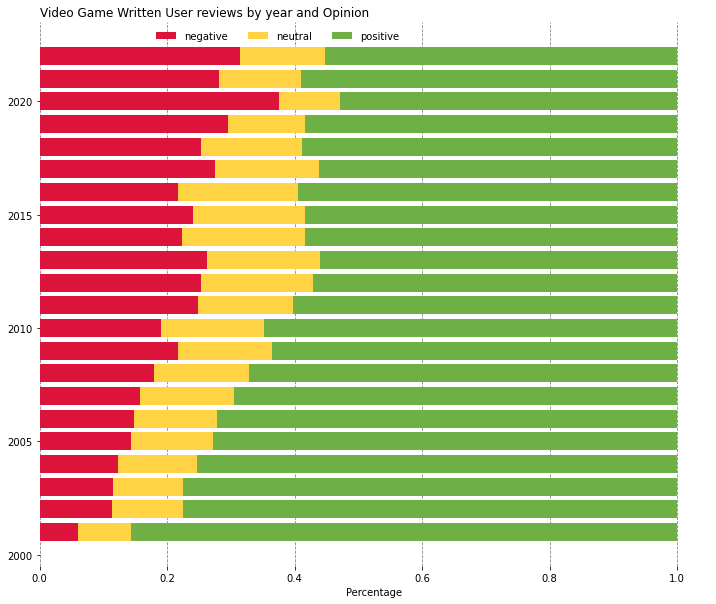

In [ ]:
#plotting the percentage of score categories in each year
fields = ['negative', 'neutral', 'positive']
colors = ['#DC143C', '#FFD343', '#6EAF46']
labels =  ['negative', 'neutral', 'positive']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(df_grouped_percentage) * [0]
for idx, name in enumerate(fields):
  plt.barh(df_grouped_percentage.index, df_grouped_percentage[name], left = left, color=colors[idx])
  left = left + df_grouped_percentage[name]
# title, legend, labels
plt.title('Video Game Written User reviews by year and Opinion', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Percentage')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
images_dir = '/content/gdrive/My Drive/plots'
plt.savefig(f"{images_dir}/opinions.png")
plt.show()

## game review aggregation <a class="anchor" id="1-2"></a>
We want to see which games concentrate the biggest number of reviews. As expected, a small number of games has received a lot of reviews and th edistribution is very skewed. 

In [ ]:

df.groupby('title').count().sort_values(by='date', ascending=False)

user_score  reviewer   date  \
title                                                                  
The Last of Us Part II                        79592     79592  79592   
Cyberpunk 2077                                21692     21692  21692   
Warcraft III: Reforged                        14212     14212  14212   
Ghost of Tsushima                              9512      9512   9512   
Death Stranding                                8772      8772   8772   
...                                             ...       ...    ...   
Dead Rising 3: The Last Agent                     1         1      1   
Dead Rising 3: Fallen Angel                       1         1      1   
Dead Rising 3: Chaos Rising                       1         1      1   
The Dark Eye : Book of Heroes                     1         1      1   
Nancy Drew: Legend of the Crystal Skull           1         1      1   

                                         user_opinion   year  
title                                                         
The Last of Us Part II                          79592  79592  
Cyberpunk 2077                                  21692  21692  
Warcraft III: Reforged                          14212  14212  
Ghost of Tsushima                                9512   9512  
Death Stranding                                  8772   8772  
...                                               ...    ...  
Dead Rising 3: The Last Agent                       1      1  
Dead Rising 3: Fallen Angel                         1      1  
Dead Rising 3: Chaos Rising                         1      1  
The Dark Eye : Book of Heroes                       1      1  
Nancy Drew: Legend of the Crystal Skull             1      1  

[11768 rows x 5 columns]

In [ ]:
count_unique_reviewers = df.groupby('reviewer').count().sort_values(by='date',ascending=False)
edges = list(zip(df.title, df.reviewer))

## Graph Creation <a class="anchor" id="1-3"></a>
The goal of the graph analysis is to investigate the evolution of the relationship between games and user through time. This has been conducted by creating different bipartite networks for each year, where the node set $A$ (games) is is linked to node set $B$ (users) when the game has been reviewed by the user. To avoid single nodes, games that haven't received any reviews, and users who haven't submitted any reviews on the year, have been disregarded. Of course, as in any bipartite network, nodes can only be linked to nodes in the opposite set, thus always yielding a clustering coefficient equal to zero. We also analysed what we called the game-game and user-user networks, those being the projections of the node sets into each other. 

In [ ]:
# function to create bipartie graph based on df
def create_bipartite(df, column_set1, column_set2, weigth_column, date_limit):
    '''
    Returns bipartite graph of games and users as well as the list of top and bottom nodes

            Parameters:
                    df (DataFrame): Dataframe containing the users and games reviewed
                    column_set1 (string): column name where the game titles are stored
                    column_set2 (string): column name where the user names are stored
                    weight column (string): column name where the edges weights are stored (score)
                    date_limit (int): year or year interval to consider 

            Returns:
                    biGraph (Graph): Bipartite graph
                    top_nodes (list): list containing the top nodes of the bipartite graph
                    bot_nodes (list): list containing the bottom nodes of the bipartite graph
    '''
    if isinstance(date_limit, int):
        date_limit = [year, year]
    else:
        df = df[(df['date'].dt.year >= date_limit[0]) & (df['date'].dt.year <= date_limit[1])]    
    titles = list(set(df[column_set1].values))
    users = list(set(df[column_set2].values))
    biGraph = nx.Graph()
    biGraph.add_nodes_from(titles, bipartite=0)
    biGraph.add_nodes_from(users, bipartite=1)
    edges = list(zip(df[column_set1], df[column_set2]))
    weights = df[weigth_column].values
    weighted_edges = []
    for edge, weight in zip(edges, weights):
        triple = (edge[0], edge[1], weight)
        weighted_edges.append(triple)
    biGraph.add_weighted_edges_from(weighted_edges)
    top_nodes = {n for n, d in biGraph.nodes(data=True) if d["bipartite"] == 0}
    bottom_nodes = set(biGraph) - top_nodes
    return biGraph, top_nodes, bottom_nodes

## Networks through time <a class="anchor" id="1-4"></a>
Instead of a incremental approach for the analysis of the network evolution through the years, a window approach was taken. That means a network for a given year only consists of the users active on that specific year. Therefore, every year, new game releases and new users enter the network, however, nodes corresponding to inactive users and games that haven't received any reviews are "dropped" from the network. This approach corresponds more to an analysis of the website dynamics, instead of the game industries', while also preventing the network from growing to large to the point of becoming a computational burden. Specific network statistics are computed, many of them having straightforward interpretation.

In [ ]:
#creating df containing graphs for each year and their statistics
%%capture --no-display
biGraph_list, top_n_nodes_list, bot_n_nodes_list, n_edges_list, avg_top_degree, avg_bot_degree, max_top_degree, max_bot_degree, top_nodes, bot_nodes= [], [], [], [], [], [], [], [], [], []
powerlaw_gamma_top, powerlaw_gamma_bot, powerlaw_gamma_general = [], [],[]
year_range = range(2001,2023)
for year in year_range:
    biGraph, top, bot = create_bipartite(df, 'title', 'reviewer', 'user_score', [year,year])
    biGraph_list.append(biGraph)
    top_n_nodes_list.append(len(top))
    bot_n_nodes_list.append(len(bot))
    n_edges_list.append(len(biGraph.edges()))
    top_degrees = list(dict(biGraph.degree(top)).values())
    bot_degrees = list(dict(biGraph.degree(bot)).values())
    degrees = list(dict(biGraph.degree()).values())
    avg_top_degree.append(np.mean(top_degrees))
    avg_bot_degree.append(np.mean(bot_degrees))
    max_top_degree.append(np.max(top_degrees))
    max_bot_degree.append(np.max(bot_degrees))
    top_nodes.append(top)
    bot_nodes.append(bot)
    bot_degrees = list(dict(biGraph.degree(bot)).values())
    #Fitting powerlaw distribution to each degree distribution (general, top and bottom nodes)
    powerlaw_top = powerlaw.Fit(top_degrees).alpha
    powerlaw_gamma_top.append(powerlaw_top)
    powerlaw_bot = powerlaw.Fit(bot_degrees).alpha
    powerlaw_gamma_bot.append(powerlaw_bot)
    powerlaw_general = powerlaw.Fit(degrees).alpha
    powerlaw_gamma_general.append(powerlaw_general)
df_years_bi = pd.DataFrame({'year': year_range, 'biGraph':biGraph_list, 'n_nodes_top': top_n_nodes_list, 'n_nodes_bot': bot_n_nodes_list, 'n_edge': n_edges_list,
                            'avg_top_degree':avg_top_degree, 'avg_bot_degree':avg_bot_degree, 'max_top_degree':max_top_degree, 'max_bot_degree':max_bot_degree, 
                            'powerlaw_top':powerlaw_gamma_top, 'powerlaw_bot':powerlaw_gamma_bot, 'powerlaw_general':powerlaw_gamma_general,
                            'top_nodes':top_nodes, 'bottom_nodes':bot_nodes})

In [ ]:
#df_years_bi = df_years_bi.set_index('year')
df_years_bi =df_years_bi.reset_index()

In [ ]:
# some more statistics
df_years_bi['game_graph'] = df_years_bi.apply(lambda x: bipartite.projected_graph(x.biGraph, x.top_nodes), axis=1)
df_years_bi['game_cluster_coef'] = df_years_bi['game_graph'].apply(lambda game_graph: nx.average_clustering(game_graph))
df_years_bi['general_assort_coef'] = df_years_bi['biGraph'].apply(lambda bigraph: nx.degree_assortativity_coefficient(bigraph))


In [ ]:
df_years_bi.head()

year                                            biGraph  n_nodes_top  \
0  2001  (Silent Hill 2: Restless Dreams, Power Stone 2...          299   
1  2002  (Star Trek: Starfleet Command III, Metropolis ...          746   
2  2003  (Star Trek: Starfleet Command III, I-Ninja, Me...         1160   
3  2004  (I-Ninja, Metropolis Street Racer, PlanetSide,...         1320   
4  2005  (I-Ninja, Heretic Kingdoms: The Inquisition, S...         1489   

   n_nodes_bot  n_edge  avg_top_degree  avg_bot_degree  max_top_degree  \
0          924    1082        3.618729        1.170996              42   
1         2731    3982        5.337802        1.458074              99   
2         5840    8954        7.716379        1.533733             401   
3         5052    7903        5.985606        1.564727             240   
4         6122    9969        6.695097        1.628389             280   

   max_bot_degree  powerlaw_top  powerlaw_bot  powerlaw_general  \
0              35      2.606488      5.780277          3.134955   
1             163      3.104715      3.931303          3.051301   
2             159      3.227339      3.434882          2.898670   
3             158      2.955794      2.829994          2.779573   
4             154      2.977587      3.540978          2.935066   

                                           top_nodes  \
0  {Silent Hill 2: Restless Dreams, Power Stone 2...   
1  {Star Trek: Starfleet Command III, Metropolis ...   
2  {Star Trek: Starfleet Command III, I-Ninja, Me...   
3  {I-Ninja, Metropolis Street Racer, PlanetSide,...   
4  {I-Ninja, Heretic Kingdoms: The Inquisition, S...   

                                        bottom_nodes  \
0  {Might, GottahateThisgame, ShavarM., AndrewV.,...   
1  {K., PoopinskiS., CrucioR., Yellow13, MikeA., ...   
2  {DeAnna, SnoopDoggydog, AlucardM., Comicbookgu...   
3  {Hellsing, JordanA., DanielH., JavaJ., ManuelP...   
4  {ArtieA., Chaser, NanopN., NilsH., DawnR., Eun...   

                                          game_graph  game_cluster_coef  \
0  (Silent Hill 2: Restless Dreams, Power Stone 2...           0.200083   
1  (Star Trek: Starfleet Command III, Metropolis ...           0.513968   
2  (Star Trek: Starfleet Command III, I-Ninja, Me...           0.532756   
3  (I-Ninja, Metropolis Street Racer, PlanetSide,...           0.519373   
4  (I-Ninja, Heretic Kingdoms: The Inquisition, S...           0.499897   

   general_assort_coef  
0            -0.216034  
1            -0.079308  
2            -0.121648  
3            -0.139868  
4            -0.158054

In [ ]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,8)
sns.set_theme()

### Evolution of network size

For measuring the network size thorough time some basic statistics were computed, those being number of nodes in each partition, and total number of edges/reviews. It was expected that the network would grow considerably from the year where the first review was submitted (2001) until today. From the following plot, we can see a clear jump in user activity from 2010 to 2011. From that point on the number of active users and reviews has seem ups and downs until it started growing again in 2019, peaking in 2020.  

In [ ]:
# cretaing chart for number of edges and nodes in each year
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df_years_bi.n_nodes_top.plot(kind='line', color='#fd084a', ax=ax)
df_years_bi.n_nodes_bot.plot(kind='bar', color='#494fc1', ax=ax2, width=width, position=0)
df_years_bi.n_edge.plot(kind='bar', color='orange', ax=ax2,  width=width, position=1)
ax.set_ylabel('N Games')
ax2.set_ylabel('N users/Edges')
ax.grid(False)
ax2.grid(False)
ax.legend(['games'])
ax2.legend(['users', 'edges'])
plt.title("Games/Users/reviews evolution through time")
plt.xticks(range(0,len(df_years_bi)),labels=df_years_bi.year.values)
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
images_dir = '/content/gdrive/My Drive/plots'
plt.savefig(f"{images_dir}/evolution.png")
plt.show()

Mounted at /content/gdrive


## Powerlaw Distributions <a class="anchor" id="1-5"></a>

Many real world networks are scale free. That means their node degrees follow a power law distribution of as following:

\begin{equation}
p(k) = Ck^{-\gamma}
\end{equation}
Where $C$ is a normalizing constant and and $\gamma$ the so called degree exponent. The network behavior or regime, can be classified by analyzing $\gamma$ and identifying in what interval it lies.


For each year, a power law distribution was estimated for the general degree distribution as well as for the distributions of the Sets of nodes $A$(Games), and $B$(Users), yielding different $\gamma_s$

It is evident by looking to the chart, that each partition as well as the general network tends to behave differently. For instance the user network seems to be indistinguishable from a random network for most of the years. The general network, on the other hand, seems to stand in the scale-free regime for most of the recorded time, while the game network, has its mode on the scale-free regime, but tends to hop into random and anomalous regime from time to time, but without abrupt changes in the exponent. 

In [ ]:
# plotting gammas dor each network in each year
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes


width = 0.4

df_years_bi.powerlaw_general.plot(kind='line', color='orange', ax=ax,style='.-')
df_years_bi.powerlaw_top.plot(kind='line', color='#494fc1', ax=ax,style='.-')
df_years_bi.powerlaw_bot.plot(kind='line', color='#fd084a', ax=ax,style='.-')
#df_years_bi.n_edge.plot(kind='bar', color='green', ax=ax2,  width=width, position=1)
ax.set_ylabel('Powerlaw Gamma')
ax.legend(['General', 'Set A (games)', 'Set B (Users)'])
#ax2.set_ylabel('Price')
ax.set_facecolor("white")
plt.axhspan(1,2, facecolor='0.2', alpha=0.3)
plt.axhspan(2,3, facecolor='b', alpha=0.3)
plt.axhspan(3,np.max(df_years_bi.powerlaw_bot)+0.5, facecolor='g', alpha=0.3)
plt.xticks(range(0,len(df_years_bi)),labels=df_years_bi.year.values)
ax.text(8.2,1.5,'ANOMOLOUS REGIME',  style ='italic',
        bbox ={'facecolor':'white',
               'alpha':0.6, 'pad':4})
ax.text(8.2,2.5,'SCALE-FREE REGIME', style ='italic',
        bbox ={'facecolor':'white',
               'alpha':0.6, 'pad':4})
ax.text(8.35,4.3,'RANDOM REGIME', style ='italic',
        bbox ={'facecolor':'white',
               'alpha':0.6, 'pad':4})
plt.title("Network Regime through time")
drive.mount('/content/gdrive', force_remount=True)
images_dir = '/content/gdrive/My Drive/plots'
plt.savefig(f"{images_dir}/powerlaws.png")
plt.show()

Mounted at /content/gdrive


## Degree Correlations <a class="anchor" id="1-6"></a>
Interesting conclusions from the network behavior can also be found by analyzing the degree correlations. this can be measured using the following relation:

\begin{equation}
r =  \sum_{jk} \frac{jk (e_{jk} - q_j q_k)}{\sigma^2} \quad \textrm{where} \quad   \sigma^2 =\textstyle   \sum_{k} k^2 q_k -[\textstyle  \sum_{k} k q_k]^2
\end{equation}
Where $e_{jk}$ is the probability of picking an edge at random in the network and having the two end nodes with degrees $j$ and $k$, and $\sum_{j} e_{ij} = q_i $. It is not hard to see that $r$ is the Pearson correlation coefficient. Thus, an assortative network has $r>0$ (high-degree nodes tend to connect to one another), a disassortative $r<0$ (high-degree nodes tend to connect to low-degree nodes), and a neutral network has $r=0$. For each year, the correlation coefficient of the networks was computed. 


In [ ]:
# creating graph for assortativity in each year
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df_years_bi.general_assort_coef.plot(kind='bar', color = '#494fc1')
ax.set_ylabel('Average Clustering Coeficient')
ax.set_title('Assortativity through the years')
plt.xticks(range(0,len(df_years_bi)),labels=df_years_bi.year.values)
plt.grid()
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
images_dir = '/content/gdrive/My Drive/plots'
plt.savefig(f"{images_dir}/assortativity.png")
plt.show()
plt.show()

Mounted at /content/gdrive


## Clustering Coefficient <a class="anchor" id="1-7"></a>

The clustering coefficient of the original bipartite network kwill always be zero, however, we can obtain the projection of the nodes $A$ into nodes $B$, what we call the Game network. In this new graph, two nodes (games) will be connected to each other if they have been reviewed by the same user, on that specific year. that way we are able to investigate how games are clustered together. 

In [ ]:
# creating graph for game cluster coefficient for each year
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
df_years_bi.game_cluster_coef.plot(kind='line', color='#fd084a', ax=ax,style='*-')

ax.set_ylabel('Average Clustering Coeficient')
ax.set_title('Nodes')
ax.fill_between(df_years_bi.game_cluster_coef.values, np.zeros(len(df_years_bi)),facecolor='#fd084a')
plt.xticks(range(0,len(df_years_bi)),labels=df_years_bi.year.values)
plt.show()

## Network Visualisation on Gephi <a class="anchor" id="1-8"></a>
To generate the pictures of the networks we made a network for every year and then loaded them in the Gephi software. The network showed in the report can be loaded in gephi with the files `*.gephi` from the [Github](https://github.com/giovanni6776/socialgraphs-MetacriticProject).

In [ ]:
for i in range(2000,2022,1):
    B, top_nodes, bottom_nodes = create_bipartite(df_only_top_reviewer,'title', 'reviewer','user_score', [i,i])
    nx.write_gexf(B, "gexf_years_new/bipartite_unprojected_%s.gexf"%i)

Here is a gif showing the evolution of the network from the year 2015 to 2021.
![gifurl](https://raw.githubusercontent.com/giovanni6776/socialgraphs-MetacriticProject/main/gif_graph2015-21.gif "graph")


# NLP Tasks - Game Aesthetics Analysis <a class="anchor" id="2"></a>

## EDA & Data Loading <a class="anchor" id="2-1"></a>

In [ ]:
# Import libraries

# Data Manipulation
import pandas as pd
import numpy as np
import project_data_utils
import os
from collections import Counter
import statistics
import pickle
from sklearn import preprocessing


#Data Viz
import seaborn as sns

# NLP libraries
from textblob import TextBlob
from textblob import Word
import spacy_fastlang
import spacy
from spacy import displacy
import nltk
import re

from nltk.probability import FreqDist
from spacy.matcher import Matcher
from spacy.matcher import DependencyMatcher

# Monitoring libraries
from tqdm import tqdm, tqdm_notebook

# Data vizualization Libraries
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import matplotlib.pylab as plt
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

### Games Dataset
The games data set contains every game launched since 2020 and it's iniquely identified by: title + plataform. Moreover, it also contains the average metascore and user_score amon other information. "It was scrapped from "https://metacritic.com/game/{`plataform`}/`title`""

In [ ]:
# Load list of games
df_games = pd.read_csv("data/metacritic_games_full.csv" ,index_col=0)

# Correct data formats
df_games['user_score'] = pd.to_numeric(df_games['user_score'],errors='coerce')
df_games['metacritic_user_differenc'] = df_games['metascore'] - df_games['user_score']

# Create metascore and user discrepancy and tranform to numeric
df_games.sort_values(by='metacritic_user_differenc')
df_games

title       platform  release_date  \
0                    Persona 5 Royal             pc  Oct 21, 2022   
1                         Elden Ring  xbox-series-x  Feb 25, 2022   
2                         Elden Ring  playstation-5  Feb 25, 2022   
3        Portal Companion Collection         switch  Jun 28, 2022   
4                    Persona 5 Royal  xbox-series-x  Oct 21, 2022   
...                              ...            ...           ...   
19634        Resident Evil: Survivor    playstation  Aug 30, 2000   
19635               ECW Anarchy Rulz      dreamcast  Dec 30, 2000   
19636  Duke Nukem: Land of the Babes    playstation  Sep 19, 2000   
19637  Mortal Kombat: Special Forces    playstation  Jun 30, 2000   
19638                     HBO Boxing    playstation  Nov 20, 2000   

                                         other_platforms  metascore  \
0      ['PlayStation 4', 'PlayStation 5', 'Switch', '...       97.0   
1      ['PC', 'PlayStation 4', 'PlayStation 5', 'Xbox...       96.0   
2      ['PC', 'PlayStation 4', 'Xbox One', 'Xbox Seri...       96.0   
3                                                    NaN       96.0   
4      ['PC', 'PlayStation 4', 'PlayStation 5', 'Swit...       95.0   
...                                                  ...        ...   
19634                                                NaN       39.0   
19635                                                NaN       38.0   
19636                                                NaN       37.0   
19637                                                NaN       28.0   
19638                                                NaN       26.0   

       user_score                       developer           publisher  \
0             8.9                           Atlus                Sega   
1             7.7                   From Software  Bandai Namco Games   
2             7.9                   From Software  Bandai Namco Games   
3             8.3                  Valve Software      Valve Software   
4             8.4                           Atlus                Sega   
...           ...                             ...                 ...   
19634         6.2                          Capcom              Capcom   
19635         6.8  Acclaim Studios Salt Lake City             Acclaim   
19636         6.9                         n-Space      GT Interactive   
19637         2.8                          Midway              Midway   
19638         4.0                  Osiris Studios             Acclaim   

                                                   genre  \
0      ['Role-Playing', ',                           ...   
1      ['Role-Playing', ',                           ...   
2      ['Role-Playing', ',                           ...   
3      ['Miscellaneous', ',                          ...   
4      ['Role-Playing', ',                           ...   
...                                                  ...   
19634  ['Action Adventure', ',                       ...   
19635  ['Action', ',                                 ...   
19636  ['Action', ',                                 ...   
19637  ['Action', ',                                 ...   
19638  ['Sports', ',                                 ...   

                     players rating  \
0      No Online Multiplayer    NaN   
1                   Up to 4       M   
2                   Up to 4       M   
3                        NaN    NaN   
4      No Online Multiplayer      M   
...                      ...    ...   
19634               1 Player      M   
19635                    NaN      M   
19636                   1-2       M   
19637               1 Player      M   
19638                    NaN      E   

                                                 summary  \
0      Prepare for an all-new RPG experience in Perso...   
1      A New World Created By Hidetaka Miyazaki And G...   
2      A New World Created By Hidetaka Miyazaki And G...   
3      Including Portal and Portal 2, the 

In [ ]:
# Check dtypes
df_games.dtypes

title                         object
platform                      object
release_date                  object
other_platforms               object
metascore                    float64
user_score                   float64
developer                     object
publisher                     object
genre                         object
players                       object
rating                        object
summary                       object
url                           object
metacritic_user_differenc    float64
dtype: object

### User Reviews Dataset
The user reviews dataset is a review-live data, coitaining all the attributes of a review

In [ ]:
# Load User Reviews
df_user_rev = pd.read_csv("data/metacritic_user_reviews_full.csv")
df_user_rev_full = df_user_rev # full copy
df_user_rev.head()

Unnamed: 0                                             url  \
0           0  https://metacritic.com/game/pc/persona-5-royal   
1           1  https://metacritic.com/game/pc/persona-5-royal   
2           2  https://metacritic.com/game/pc/persona-5-royal   
3           3  https://metacritic.com/game/pc/persona-5-royal   
4           4  https://metacritic.com/game/pc/persona-5-royal   

             title platform  user_score        reviewer  \
0  Persona 5 Royal       pc          10         Trix122   
1  Persona 5 Royal       pc           7          Runwin   
2  Persona 5 Royal       pc          10       Godskrieg   
3  Persona 5 Royal       pc          10    jackspade152   
4  Persona 5 Royal       pc          10  MLGANDREWPLAYS   

                                              review          date  \
0  \n100+ h of main story , good gameplay and pro...  Oct 25, 2022   
1  El juego tiene una cantidad de relleno abrumad...  Oct 26, 2022   
2  \nAbsolute god of recent JRPGs.\rIf you like t...  Oct 24, 2022   
3  \nSimply amazing. I finished this Game on ps4 ...  Oct 25, 2022   
4  People have been waiting for a long time for t...  Oct 25, 2022   

  review_type                                           url_page  
0        user  https://metacritic.com/game/pc/persona-5-royal...  
1        user  https://metacritic.com/game/pc/persona-5-royal...  
2        user  https://metacritic.com/game/pc/persona-5-royal...  
3        user  https://metacritic.com/game/pc/persona-5-royal...  
4        user  https://metacritic.com/game/pc/persona-5-royal...

#### Remove platform granularity
The same game can be distributed in multiple platforms, however since this is not our research interest, here we remove platforma granularity to inspect the data

In [ ]:
# Group by title so we remove the platform granularity
df_user_rev.groupby(['title']).size().sort_values()

# Group by and perform and a series of operations
df_user_rev = df_user_rev.groupby(['title']).agg({'url':'count', 'user_score':'mean', 'reviewer':'count'}).sort_values(by='url')
df_user_rev = df_user_rev.rename(columns={'url':'num_user_reviews', 'user_score': 'avg_user_score', 'reviewer':'num_user_reviewers'})
df_user_rev.sort_values(by='num_user_reviews', ascending=False)

num_user_reviews  avg_user_score  \
title                                                              
Cyberpunk 2077                             12058        5.056394   
Warcraft III: Reforged                     10100        0.070198   
The Last of Us Part II                     10100        4.112376   
Ghost of Tsushima                           9505        9.289637   
Death Stranding                             8764        7.219763   
...                                          ...             ...   
Trulon: The Shadow Engine                      1        6.000000   
Tumblestone                                    1        0.000000   
Fallen Legion: Revenants                       1        9.000000   
Oblitus                                        1        4.000000   
void tRrLM(); //Void Terrarium                 1       10.000000   

                                num_user_reviewers  
title                                               
Cyberpunk 2077                               12058  
Warcraft III: Reforged                       10100  
The Last of Us Part II                       10100  
Ghost of Tsushima                             9505  
Death Stranding                               8764  
...                                            ...  
Trulon: The Shadow Engine                        1  
Tumblestone                                      1  
Fallen Legion: Revenants                         1  
Oblitus                                          1  
void tRrLM(); //Void Terrarium                   1  

[6438 rows x 3 columns]

### Join on the Games DF the aggregate of User and Critic Reviews

In [ ]:
# join on user_rev
df = df_games.merge(df_user_rev, on='title', how='left', indicator=True)
df = df.rename(columns={'_merge': 'merge_indicator_user_revs'})

In [ ]:
# join on critic_rev
df = df.merge(df_critic_rev, on='title', how='left', indicator=True)
df = df.rename(columns={'_merge': 'merge_indicator_critic_revs'})
df

NameError: name 'df_critic_rev' is not defined

In [ ]:
print('before droppping rows with null reviews: ', df.shape)
print('after droppping rows with null reviews: ', df.dropna(subset=['num_user_reviews']).shape)

# drop games without user reviews
df = df.dropna(subset=['num_user_reviews'])

before droppping rows with null reviews:  (19639, 18)
after droppping rows with null reviews:  (10751, 18)


### Define Games to be Analysized
Due to memory constraints, we're not analysing all of the games, instead, we decided to analyze the top 50 most commented games. This will account for 227908 User Reviews.

In [ ]:
# Get rid of the plataform granularity
df = df.groupby('title').first()
df = df.sort_values(by='num_user_reviews', ascending=False).head(50) # CHANGE HERE IN ORDER TO SELECT MORE GAMES

In [ ]:
# Get the top N games and pass to a list
lst_games = df.index.tolist()
print(lst_games)
print("Number of games to be analyzed: ", len(lst_games))

['Cyberpunk 2077', 'The Last of Us Part II', 'Warcraft III: Reforged', 'Ghost of Tsushima', 'Death Stranding', 'Call of Duty: Modern Warfare 3', 'Red Dead Redemption 2', 'Gran Turismo 7', 'Elden Ring', 'Call of Duty: Modern Warfare', 'The Legend of Zelda: Breath of the Wild', 'God of War', 'The Witcher 3: Wild Hunt', "Assassin's Creed Valhalla", 'The Elder Scrolls V: Skyrim', 'Diablo III', 'DOOM Eternal', 'Fallout 76', 'Grand Theft Auto V', 'Horizon Forbidden West', 'Fallout 4', 'Days Gone', 'Madden NFL 21', 'Mass Effect 3', 'Animal Crossing: New Horizons', 'Dota 2', 'Star Wars Battlefront II', 'Battlefield 2042', 'The Last of Us Remastered', 'Halo Infinite', "Uncharted 4: A Thief's End", 'Battlefield 3', 'Dragon Age II', 'Pokemon Sword', 'Diablo Immortal', 'BioShock Infinite', 'Horizon Zero Dawn', 'Portal 2', 'Mass Effect: Andromeda', 'The Last of Us', 'Grand Theft Auto: The Trilogy - The Definitive Edition', 'Sekiro: Shadows Die Twice', 'Destiny', 'Bloodborne', "No Man's Sky", 'Star 

In [ ]:
# Select only a subset of the reviews based on the lst_games
df_user_rev = df_user_rev_full[df_user_rev_full['title'].isin(lst_games)]
print('Number of reviews: ' ,df_user_rev.shape)

Number of reviews:  (227908, 10)


## Text pre-processing <a class="anchor" id="2-2"></a>
Perfom all the pre-processing tasks on the review text.

### Filter Long-reviews

Here we removed the reviews with a word_count > 600 as this will considerably slow down the parsing into the Spacy Object.

In [ ]:
# Create word Count 
df_user_rev['word_count'] = df_user_rev['review'].apply(lambda x: len(str(x).split()))

df_user_rev['word_count'].iplot(
    kind='hist',
    bins=300,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution',
    )

In [ ]:
print("Before filtering long reviews: ", len(df_user_rev['word_count']))
# select languages with only English Reviews
df_user_rev = df_user_rev[df_user_rev['word_count'] < 600]
print("After filtering: ", len(df_user_rev['word_count']))

Before filtering long reviews:  227908
After filtering:  223699


### Clean Text
Since most of the text is already cleaned from the scrapper process, here very little has to be done

In [ ]:
# Function to clean the text
def preprocess(text):
    text = text.replace('\n', "")
    text = text.replace('\r', "")
    text = re.sub(' +', ' ', text) #remove multiple spaces on the text
    return text

In [ ]:
# Apply preprocess fuction
tqdm.pandas()
df_user_rev['review'] = df_user_rev['review'].progress_apply(lambda x: preprocess(x))

100%|██████████| 223699/223699 [00:08<00:00, 27191.88it/s]


In [ ]:
#inspect the text
print('3 random review \n')
cl = df_user_rev.sample(3)['review'].values
for c in cl:
    print(c)

3 random review 

Pay to win method. Overpriced cars. Graphics are almost as GT Sport. Nothing that much new. Sad way to sell the game. Greed for money
The Last of Us. Extremely favorable reviews seem to follow this game everywhere. But I cannot seem to figure out why. Graphics are OK. Nothing special, nothing new. I myself found FarCry 3's graphics much better. I am a huge fan of survival horror games but this is neither. It's just a stealth game with limited ammo, and the gameplay is clunky and repetitive. The story is boring and predictable and never really shines. The characters are drab and I forgot about them as soon as I finished the game. I had to force myself to finish it by the way. I am appalled at the good reviews this game has been getting. Do yourself a huge favor, Rent first! One of the WORST games I have ever played. Shame on you developers and critics alike.
Tried this game out release day. Turned it off and returned it and got my money back after playing 5 games onlin

### Create column with Spacy Objects for each Review
After a basic cleaning of the text, we create a column with the spacy object DOC for each review
.
Since there's lof of reviews and when we ran everything at once the kernel crashed. We decided to split reviews dataframe in 5 dataframes, and produce a pickle file for each of them with the serialized SpacyObject.


In [ ]:
# Load neccessary libraries in other to detect the language and perform other operations
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("language_detector")

In [ ]:
# Uncommet if you want to generate the pickle files.
# for i, df in enumerate(np.array_split(df_rp, 5)):
#     df.to_pickle(f"data{i+1}.pkl")

#### Get Working Dataframe from Pickle Files
In the section above we create the pickle files.
Here we concatate them and create the dataframe with spaCy objects that will be used for the rest of the analysis 

In [ ]:
# concat the dataframes from the picke files
unpickled_df1 = pd.read_pickle("data/data1.pkl")
unpickled_df2 = pd.read_pickle("data/data2.pkl")
unpickled_df3 = pd.read_pickle("data/data3.pkl")
unpickled_df4 = pd.read_pickle("data/data4.pkl")
unpickled_df5 = pd.read_pickle("data/data5.pkl")

df_user_rev = pd.concat([unpickled_df1,unpickled_df2,unpickled_df3,unpickled_df4,unpickled_df5 ])

In [ ]:
# Final Data Frame
df_user_rev

Unnamed: 0                                                url  \
31              31  https://metacritic.com/game/xbox-series-x/elde...   
32              32  https://metacritic.com/game/xbox-series-x/elde...   
33              33  https://metacritic.com/game/xbox-series-x/elde...   
34              34  https://metacritic.com/game/xbox-series-x/elde...   
35              35  https://metacritic.com/game/xbox-series-x/elde...   
...            ...                                                ...   
723835      723835  https://metacritic.com/game/wii/call-of-duty-m...   
723836      723836  https://metacritic.com/game/wii/call-of-duty-m...   
723837      723837  https://metacritic.com/game/wii/call-of-duty-m...   
723838      723838  https://metacritic.com/game/wii/call-of-duty-m...   
723839      723839  https://metacritic.com/game/wii/call-of-duty-m...   

                                 title       platform  user_score  \
31                          Elden Ring  xbox-series-x          10   
32                          Elden Ring  xbox-series-x           7   
33                          Elden Ring  xbox-series-x           3   
34                          Elden Ring  xbox-series-x           0   
35                          Elden Ring  xbox-series-x          10   
...                                ...            ...         ...   
723835  Call of Duty: Modern Warfare 3            wii          10   
723836  Call of Duty: Modern Warfare 3            wii          10   
723837  Call of Duty: Modern Warfare 3            wii           8   
723838  Call of Duty: Modern Warfare 3            wii          10   
723839  Call of Duty: Modern Warfare 3            wii           0   

              reviewer                                             review  \
31          Sekiro1990  The best game from FROM SOFTWARE so farSome fr...   
32          Netherghul  Not a terrible game. But failing of expectatio...   
33      MingledLotus24  I dont like it too much. Neither aesthetics, n...   
34            SlavisaT  the game is big garbage, the world is empty, g...   
35             Jakob44  The game is good, no microtransactions and a f...   
...                ...                                                ...   
723835     Wesleytorna  Call of duty modern warfare 3 on the wii is a ...   
723836    broken_glass  bought this game at gamestop for cheap used an...   
723837   PotatoAim1805  This version of the game is very underrated an...   
723838      AidasKar15  I love campaign and multiplayer with friends a...   
723839      kozachenko  this is an absolute rubbish console port for t...   

                date review_type  \
31      Feb 27, 2022        user   
32      Mar  6, 2022        user   
33      Apr  3, 2022        user   
34      Feb 28, 2022        user   
35      Apr 10, 2022        user   
...              ...         ...   
723835  Jan 18, 2020        user   
723836  Apr 19, 2020        user   
723837  Jun 23, 2020        user   
723838  Oct 21, 2020        user   
723839  Sep 30, 2022        user   

                                                 url_page  word_count  \
31      https://metacritic.com/game/xbox-series-x/elde...          18   
32      https://metacritic.com/game/xbox-series-x/elde...         175   
33      https://metacritic.com/game/xbox-series-x/elde...          64   
34      https://metacritic.com/game/xbox-series-x/elde...          16   
35      https://metacritic.com/game/xbox-series-x/elde...          16   
...                                                   ...         ...   
723835  https://metacritic.com/game/wii/call-of-duty-m...          27   
723836  https://metacritic.com/game/wii/call-of-duty-m...          46   
723837  https://metacritic.com/game/wii/call-of-duty-m...         109   
723838  https://metacritic.com/game/wii/call-of-duty-m...          22   
723839  https://metacritic.com/game/wii/call-of-duty-m...          58   

                                         review_spacy_obj  
31     

In [ ]:
print("The column review_spacy_obj is of the:" , type(df_user_rev.at[31, 'review_spacy_obj']))
# With this column we can apply whichever methods and operations spacy's allow us.

The column review_spacy_obj is of the: <class 'spacy.tokens.doc.Doc'>


In [ ]:
# Uncomment to inspect how spacy objects behave

# doc = df_user_rev.at[33592, 'review_spacy_obj']

# print(" ".join([token.text for token in doc]))

# print(" ".join([token.lemma_ for token in doc]))
# print(type(" ".join([token.lemma_ for token in doc])))

### Filter out non Enlgish Reviews

Samping the data we noticed that the dataset contained reviews in multiple languagues. In this section, we'll investitage this.

Even though spaCy's language detection does not detect all languages perfectly, based on our tests, it does a great job in detecting what is non Enlish.

In [ ]:
# Create column with language
df_user_rev['language'] =  df_user_rev['review_spacy_obj'].progress_apply(lambda doc: doc._.language)

100%|██████████| 223699/223699 [00:05<00:00, 40766.04it/s] 


In [ ]:
print("Before filtering out non-english reviews: ", len(df_user_rev['language']))
# select languages with only English Reviews
df_user_rev = df_user_rev[df_user_rev['language'] == 'en']
print("Only english reviews: ", len(df_user_rev['language']))

Before filtering out non-english reviews:  191108
Only english reviews:  191108


### Lemmatization
Since we already have the spacy doc obj we simply perform an interation over the token and return it the text verion of the lemma 

In [ ]:
# Download packages in order to lemmatize
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/gio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/gio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Function to lemmatize sentence
def lemmatize_spacy(doc):
    return " ".join([token.lemma_ for token in doc])

In [ ]:
# Lemmatize words
df_user_rev['lemmatized_user_rev'] = df_user_rev['review_spacy_obj'].progress_map(lambda doc: lemmatize_spacy(doc))

100%|██████████| 191108/191108 [02:00<00:00, 1586.44it/s]


In [ ]:
# inspect some reviews
print('3 Lemmatized Reviews: \n')
cl = df_user_rev.loc[df_user_rev.user_score > 0, ['lemmatized_user_rev']].sample(3).values
for c in cl:
    print(c[0])

3 Lemmatized Reviews: 

spectacular game . no doubt . I know I be late to this but I just buy it after play rdr2 , and put 16 in 2 day into this game .
wonderful and tempting game that be hard to stop play be a challenge and a relief to complete
just remember , you be bad at the game do not make the game bad . Parry Souls .


## Pattern Matching <a class="anchor" id="2-3"></a>

In order to find Nouns and its Adjectives, we use the `Matcher` class from Spacy, in which we have to provide a patern, which in our case were:
* Adjectival Modifier (Adjective + Noun): "smooth gameplay", "fast gameplay"
* Ajectival Complement: (Adjective + LEMMA "be" + noun): "the graphics was smooth" 

Based on this pattern, it returns the NOUN + Adjective. We then iterated over every review of all of the games and stored in a dictionary called `noun_adj_count`. The strucutre of the dictionary is describe below

**Goal** is to get the top words that describe certain important features of a game (e.g. gameplay, story and so on).

**How:** We extracted all the adjectives which were used as a pre-nominal modifier to every noun (e.g. “good gameplay”) or as an adjectival complement of “gameplay” (e.g. “story was smooth”. 
* We plan to achieve something like this: Cyber Punk - Gameplay : (smooth: 30, fast:24, tedious: 20), Graphics: (low-quality: 30, ...)

**Usage:** Foreseeing a business application, we can use this feature to provide a more detail description of the game "The gameplay is best described by the users as "Smooth, fast, and exciting"


### Match Adjectival Modifier and Ajectival Complement for every Noun



In [ ]:
# DEFINE MATCHER AND PATTERNS
matcher = Matcher(nlp.vocab)

# this pattern will match adjectival modifier for exemple: "smooth gameplay", "tedious characters"
pattern_adj_noun = [
        {'POS': {'IN': ['ADJ']}}, 
        {'POS': {'IN': ['NOUN']}}
        ]# IN is used instead of adding all the patterns mannually.

# this pattern will match adjecvtival complements e.g."gameplay was smooth", "gameplay is smooth", 
# which based on our EDA is a very commom form of describing the words
pattern_noun_lemma_adj = [
        {'POS': {'IN': ['NOUN']}}, 
        {'LEMMA': {'IN': ['be']}},
        {'POS': {'IN': ['ADJ']}},
]

# Add both patterns
matcher.add('adj_noun', [pattern_adj_noun])
matcher.add('noun_lemma_adj', [pattern_noun_lemma_adj])

In [ ]:
# This function updates a global variable noun_adj_count, which holds a count of every adjective for each noun and game in the a dataframe
''' 
* input -> Title game (string), review (spacy Doc object), mathcer (Matcher object)
* outputs -> 
    {GAME :
        {NOUN : 
            {ADJ : COUNT},
            {ADJ : COUNT}},
        {NOUN :
            {ADJ : COUNT},
            {ADJ : COUNT}
            }
    }
    For a particular GAME is possible to have multiple NOUNs and multiple ADJs that describe that particular noun. And these adjectives can appear multiple times.
'''

def count_adjs(game, review, matcher):
    matches = matcher(review) #Pass the review into a matcher object
    for match_id, start, end in matches: #loop through everty match 
        
        # Depending on the rule, the adj and noun are placed different in the text span returned by spacy
        # case 1 when rule is "noun + lemma = be + adj"
        if nlp.vocab.strings[match_id] == "noun_lemma_adj":
            # "gameplay was smooth"
            noun_modified = review[start].lower_ #get the lower case of the noun
            adj_modifier = review[end-1].lower_ #get the lower case fo the adj

        # case 2 when the rule is "adj_noun"
        if nlp.vocab.strings[match_id] == "adj_noun":
            # "gameplay was smooth"
            adj_modifier = review[start].lemma_.lower() #get the lower case of the adj
            noun_modified = review[end-1].lemma_.lower() #get the lower case fo the noun

        # UPDATE DICTIONARY
        # Add game if doesn't exist in the dictionary
        if game not in noun_adj_count.keys():
            noun_adj_count[game] = {}
        else:
            pass

        # Add noun if don't exist in a specific game
        if noun_modified not in noun_adj_count[game].keys():
            noun_adj_count[game][noun_modified] = {}
        else:
            pass
        
        # Add count of a specific adjective for a specific noun and game
        if adj_modifier in noun_adj_count[game][noun_modified].keys():
            noun_adj_count[game][noun_modified][adj_modifier] += 1
        else:
            noun_adj_count[game][noun_modified][adj_modifier] = 1

In [ ]:
# Uncomment to test the matcher
# doc = nlp("The smooth gameplayssx")
# matches = matcher(doc)

# adj_count = {}
# count_adjs(doc, matcher=matcher)
# adj_count

In [ ]:
# iterate over the reviews and games and uptdate the global variable "adj_count"
noun_adj_count = {}

df_user_rev.progress_apply(lambda review: count_adjs(game = review['title'], review=review['review_spacy_obj'], matcher=matcher), axis=1)

In [ ]:
# store noun_adj_coun to facilitate use
# %store noun_adj_count

Stored 'noun_adj_count' (dict)


In [ ]:
print("Number of games in the dictionary:", len(noun_adj_count.keys()))

Number of games in the dictionary: 50


In [ ]:
# Uncomment to inspect specific games
# print(pd.DataFrame(adj_count['Cyberpunk 2077']['gameplay'], index=['count']).T.sort_values(by='count', ascending=False))
# print()
# print(pd.DataFrame(adj_count['gameplay'], index=['count']).T.sort_values(by='count', ascending=False).sum())

### Statistical Analysis
Here we perform some basic statisical analysis to visualize the most commom noun and adjectives.

In [ ]:
# Load noun_adj_count dictionary
%store -r noun_adj_count

#### Distribution of Nouns

In [ ]:
# Dictionary stores the count of each NOUN
noun_count = {}

for game in noun_adj_count:
    for noun in noun_adj_count[game]:
        for adj in noun_adj_count[game][noun]:
            if noun not in noun_count.keys():
                noun_count[noun] = noun_adj_count[game][noun][adj]
            else:
                noun_count[noun] += noun_adj_count[game][noun][adj]

df_noun_count = pd.DataFrame.from_dict(noun_count, orient='index').reset_index()
df_noun_count.columns = ['noun', 'count']

df_noun_count['% Occurance'] = df_noun_count['count'] / df_noun_count['count'].sum() * 100

df_noun_count.sort_values(by='count', ascending=False, inplace=True)
df_noun_count.head(10)

noun   count  % Occurance
0          game  123242    13.706607
24        story   27601     3.069701
2         world   21604     2.402732
39        thing   17231     1.916380
8          time   16836     1.872450
98     gameplay   12503     1.390546
33       player   12339     1.372307
189   character   11832     1.315920
21      graphic   10440     1.161106
79   experience    8274     0.920210

In [ ]:
print("Number of Nouns: ", len(df_noun_count))

Number of Nouns:  20728


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'game'),
  Text(1, 0, 'story'),
  Text(2, 0, 'world'),
  Text(3, 0, 'thing'),
  Text(4, 0, 'time'),
  Text(5, 0, 'gameplay'),
  Text(6, 0, 'player'),
  Text(7, 0, 'character'),
  Text(8, 0, 'graphic'),
  Text(9, 0, 'experience')])

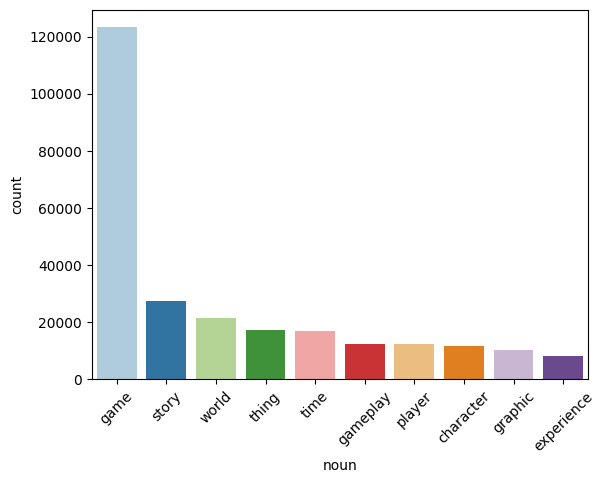

In [ ]:
sns.set_palette("Paired")
sns.barplot(data=df_noun_count.head(10), x="noun", y="count")
plt.xticks(rotation=45)

#### Distribution of Adjectives

In [ ]:
adj_count = {}

for game in noun_adj_count:
    for noun in noun_adj_count[game]:
        for adj in noun_adj_count[game][noun]:
            if adj not in adj_count.keys():
                adj_count[adj] = noun_adj_count[game][noun][adj]
            else:
                adj_count[adj] += noun_adj_count[game][noun][adj]

df_adj_count = pd.DataFrame.from_dict(adj_count, orient='index').reset_index()
df_adj_count.columns = ['adj', 'count']

df_adj_count['% Occurance'] = df_adj_count['count'] / df_adj_count['count'].sum() * 100


df_adj_count.sort_values(by='count', ascending=False, inplace=True)
df_adj_count.sort_values(by='count', ascending=False).head(10)

adj  count  % Occurance
0       good  58126     6.464600
24     great  36639     4.074880
124      new  23803     2.647299
21       bad  20325     2.260486
18     other  17738     1.972767
6    amazing  16974     1.887798
136     many  15547     1.729091
27     first  15282     1.699618
17      same  14961     1.663918
96      more  14552     1.618430

In [ ]:
print("Number of Nouns: ", len(df_adj_count))

Number of Nouns:  14224


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'good'),
  Text(1, 0, 'great'),
  Text(2, 0, 'new'),
  Text(3, 0, 'bad'),
  Text(4, 0, 'other'),
  Text(5, 0, 'amazing'),
  Text(6, 0, 'many'),
  Text(7, 0, 'first'),
  Text(8, 0, 'same'),
  Text(9, 0, 'more')])

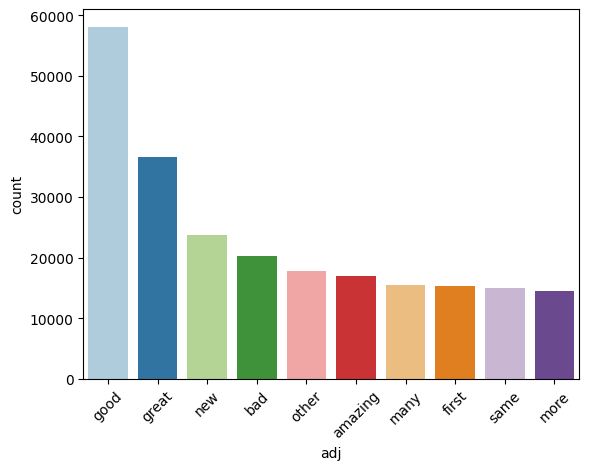

In [ ]:
sns.barplot(data=df_adj_count.head(10), x="adj", y="count")
plt.xticks(rotation=45)

### Sentiment for each Noun

Here we calculate the weighted average of the sentimet scores for each Noun. To achieve that:

1. we get the TextBlob polarity score for each adjective which the output lies between [-1,1], where -1 refers to negative sentiment and +1 refers to positive sentiment.
2. Calculate the weigheted average for that adjective based on its count
3. Sums the weigheted average for every adjective for that particular noun
4. Repeat this process for every game.

At the end, we obtain `game_noun_polarity`, which has the following structure:

    {GAME :
        {NOUN : Polarity Score
        {NOUN : Polarity Score
    }
    

In [ ]:
# Get game + noun and its polarity score
game_noun_polarity ={}

for game in noun_adj_count: # loop through all games
    if game not in game_noun_polarity:
        game_noun_polarity[game] = {}
    for noun in noun_adj_count[game]:
        if noun not in game_noun_polarity[game]:
            game_noun_polarity[game][noun] = 0
            weighet = sum(noun_adj_count[game][noun].values()) # get the weight (sum of the count of adjectives for that specific noun and game)
            noun_score = 0 # initialize noun_score which will be update with the weigheted score for every adjective
        for adj in noun_adj_count[game][noun]:
            count_adj = noun_adj_count[game][noun][adj] # get the count for the adjective
            sentiment_score = TextBlob(adj).sentiment.polarity # get the sentiment for the adjective
            adj_score = (count_adj / weighet) * sentiment_score # for every adjecitve calculates its weigheted score
            noun_score += adj_score # add to the cumulative noun_score, which stores the weighet sum for all adjectives
        
        game_noun_polarity[game][noun] = "{:.2f}".format(noun_score) # out of the adjectives loop, store the final weighet score fore that noun

In [ ]:
game_noun_polarity.keys()

dict_keys(['Elden Ring', 'God of War', 'Horizon Forbidden West', 'Gran Turismo 7', "No Man's Sky", 'Grand Theft Auto V', 'Cyberpunk 2077', 'Diablo Immortal', 'Halo Infinite', 'Days Gone', 'Battlefield 2042', 'Grand Theft Auto: The Trilogy - The Definitive Edition', 'The Last of Us Part II', 'Animal Crossing: New Horizons', 'DOOM Eternal', 'Death Stranding', "Assassin's Creed Valhalla", 'Ghost of Tsushima', 'Madden NFL 21', 'Warcraft III: Reforged', 'Red Dead Redemption 2', 'Sekiro: Shadows Die Twice', 'Star Wars Jedi: Fallen Order', 'Call of Duty: Modern Warfare', 'Pokemon Sword', "Marvel's Spider-Man", 'Fallout 76', 'The Legend of Zelda: Breath of the Wild', 'Horizon Zero Dawn', 'The Elder Scrolls V: Skyrim', 'Mass Effect: Andromeda', 'Star Wars Battlefront II', "Uncharted 4: A Thief's End", 'The Witcher 3: Wild Hunt', 'Bloodborne', 'Fallout 4', 'The Last of Us Remastered', 'Dragon Age: Inquisition', 'Watch Dogs', 'Destiny', 'The Last of Us', 'BioShock Infinite', 'Dota 2', 'Diablo III

In [ ]:
# inspect specific games and nouns
game_noun_polarity['The Last of Us Part II']['experience']

'0.24'

## Words that describe Gameplay, Graphics, Story, Characters <a class="anchor" id="2-4"></a>

As expected the most used word are simple adjectives such as: Good, great, bad. However, they describe the game in certain aspects, we became interested in analysing more descriptive adjectives, like: (emergent, stressful, ). For example, “emergent gameplay” has been described as a way to empower the player and ultimately allow for a more satisfying and interesting gameplay experience (Sweetser & Wiles, 2005).


In [ ]:
# Firstly, we tranform the dictionary into a Multi-index dataframe, which will help us to navigate teh data.
df_game_noun_polarity = pd.concat({
                                    k: pd.DataFrame.from_dict(v, orient='index') for k, v in game_noun_polarity.items()
                                }, 
                                axis=0)

df_game_noun_polarity.columns = ['polarity'] 
df_game_noun_polarity = df_game_noun_polarity.reset_index()
df_game_noun_polarity.columns = ['title', 'noun', 'polarity']
df_game_noun_polarity['polarity'] = df_game_noun_polarity['polarity'].astype(float)
df_game_noun_polarity['polarity'] = df_game_noun_polarity['polarity'].apply(lambda x: (x+1)/2 * 10)
df_game_noun_polarity

title       noun  polarity
0         Elden Ring       game      6.70
1         Elden Ring      frame      4.65
2         Elden Ring      world      5.30
3         Elden Ring       loot      6.60
4         Elden Ring     bosses      6.00
...              ...        ...       ...
98841  Dragon Age II    student      5.00
98842  Dragon Age II  curiosity      5.00
98843  Dragon Age II      anger      5.00
98844  Dragon Age II   sets+all      5.00
98845  Dragon Age II     stream      4.40

[98846 rows x 3 columns]

In [ ]:
# Load the data to df_sentiment
df_sentiment = df_user_rev_full 

# Group by title to remove the plataform granularity and perform and a series of operations
df_sentiment = df_sentiment.groupby(['title']).agg({'url':'count', 'user_score':'mean'}).sort_values(by='url')
df_sentiment = df_sentiment.rename(columns={'url':'num_user_reviews', 'user_score': 'avg_user_score'}).reset_index()
# Select only analyzed games (top 50)
df_sentiment = df_sentiment[df_sentiment['title'].isin(lst_games)]
# df_sentiment.sort_values(by='num_user_reviews', ascending=False)

In [ ]:
# ADD noun and its respective polarity for each game in the lst_games
nouns_colums = ['gameplay', 'story', 'character', 'graphic']

for noun in nouns_colums:
    df_sentiment = df_sentiment.merge(df_game_noun_polarity[df_game_noun_polarity['noun'] == noun][['title','polarity']], on='title', how='left', indicator=False)
    df_sentiment = df_sentiment.rename(columns={'polarity':f'{noun}_polarity'})

#### Get Discrepancies for each Features
In order to sort the values, here it's calculated the discrepancies for each of the festures. The discrepancy can be seen as "How the users rated different features of the game". A low discrepancy means that all the features are perceived equal. 

In [ ]:
# Add a discrepancy colum for each feature 
df_sentiment['graphic_discrepancy'] = abs(df_sentiment['graphic_polarity'] - df_sentiment['character_polarity']) + abs(df_sentiment['graphic_polarity'] - df_sentiment['story_polarity']) + abs(df_sentiment['graphic_polarity'] - df_sentiment['gameplay_polarity'])
df_sentiment['gameplay_discrepancy'] = abs(df_sentiment['gameplay_polarity'] - df_sentiment['character_polarity']) + abs(df_sentiment['gameplay_polarity'] - df_sentiment['story_polarity']) + abs(df_sentiment['gameplay_polarity'] - df_sentiment['graphic_polarity'])
df_sentiment['character_discrepancy'] = abs(df_sentiment['character_polarity'] - df_sentiment['gameplay_polarity']) + abs(df_sentiment['character_polarity'] - df_sentiment['story_polarity']) + abs(df_sentiment['character_polarity'] - df_sentiment['graphic_polarity'])
df_sentiment['story_discrepancy'] = abs(df_sentiment['story_polarity'] - df_sentiment['gameplay_polarity']) + abs(df_sentiment['story_polarity'] - df_sentiment['character_polarity']) + abs(df_sentiment['story_polarity'] - df_sentiment['graphic_polarity'])

# Add a a sum of all discrepancies.
df_sentiment['game_discrepancy'] = df_sentiment['graphic_discrepancy'] + df_sentiment['gameplay_discrepancy'] + df_sentiment['character_discrepancy'] + df_sentiment['story_discrepancy']

In [ ]:
df_sentiment.sort_values(by='game_discrepancy', ascending=False)

title  num_user_reviews  \
47                             The Last of Us Part II             10100   
45                                    Death Stranding              8764   
7                                             Destiny              2476   
32                                         Fallout 76              4691   
23                           Star Wars Battlefront II              3678   
43                              Red Dead Redemption 2              7848   
9   Grand Theft Auto: The Trilogy - The Definitive...              2604   
13                                  Horizon Zero Dawn              2657   
15                                    Diablo Immortal              2720   
42                                     Gran Turismo 7              7176   
5                                        No Man's Sky              2345   
36                          Assassin's Creed Valhalla              5064   
1                                 Marvel's Spider-Man              2212   
18                                      Battlefield 3              3063   
6                                          Bloodborne              2465   
25                      Animal Crossing: New Horizons              3908   
33                                       DOOM Eternal              4940   
10                                     The Last of Us              2617   
46                                  Ghost of Tsushima              9505   
16                                      Pokemon Sword              2890   
17                                      Dragon Age II              2979   
28                                          Days Gone              4182   
8                           Sekiro: Shadows Die Twice              2567   
30                             Horizon Forbidden West              4562   
40                       Call of Duty: Modern Warfare              6587   
31                                 Grand Theft Auto V              4584   
49                                     Cyberpunk 2077             12058   
19                         Uncharted 4: A Thief's End              3142   
2                             Dragon Age: Inquisition              2236   
27                                      Madden NFL 21              3997   
11                             Mass Effect: Andromeda              2635   
48                             Warcraft III: Reforged             10100   
38                                         God of War              5756   
4                        Star Wars Jedi: Fallen Order              2325   
35                        The Elder Scrolls V: Skyrim              5036   
37                           The Witcher 3: Wild Hunt              5468   
20                                      Halo Infinite              3204   
14                                  BioShock Infinite              2690   
41                                         Elden Ring              7070   
39            The Legend of Zelda: Breath of the Wild              5844   
21                          The Last of Us Remastered              3282   
12                                           Portal 2              2639   
34                                         Diablo III              4966   
3                                Call of Duty: Ghosts              2314   
24                                             Dota 2              3704   
22                                   Battlefield 2042              3557   
44                     Call of Duty: Modern Warfare 3              8401   
29                                          Fallout 4              4186   
0                                          Watch Dogs              2153   
26                                      Mass Effect 3              3961   

    avg_user_score  gameplay_polarity  story_polarity  character_polarity  \
47        4.112376               6.30            4.70                5.75   
45        7.219763               5.05            6.90               

#### Statical Analysis of the Features

In [ ]:
df_sentiment.describe()

num_user_reviews  avg_user_score  gameplay_polarity  story_polarity  \
count         50.000000       50.000000          50.000000        50.00000   
mean        4558.160000        6.033655           6.017000         6.22400   
std         2449.608851        2.781681           0.856286         0.90769   
min         2153.000000        0.070198           3.650000         3.20000   
25%         2643.500000        4.149153           5.537500         5.66250   
50%         3806.000000        6.639453           6.250000         6.22500   
75%         5367.000000        8.518784           6.600000         7.03750   
max        12058.000000        9.341796           7.200000         7.55000   

       character_polarity  graphic_polarity  
count           50.000000         50.000000  
mean             5.955000          6.733000  
std              0.730966          1.419385  
min              2.800000          3.800000  
25%              5.762500          5.462500  
50%              6.000000          7.400000  
75%              6.337500          7.900000  
max              7.100000          8.350000